In [1]:
import os
import nnmnkwii.datasets.jvs
from nnmnkwii.io import hts
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchaudio
import pytorch_lightning as pl
import itertools
from matplotlib import pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn as sk

# model

In [3]:
from model.child import Encoder, Decoder, Discriminator

ImportError: cannot import name 'Encoder' from 'model.child' (/work/kenya/splitternet/model/child.py)

In [4]:
from model.main import SplitterNet

# data

## transform

In [5]:
from data.dataset import TransSqueeze, TransChunked

## dataset

In [6]:
from data.dataset import JVSDataset

# 入力確認

In [7]:
model = SplitterNet()
model.test_input()

encoder out *2
torch.Size([64, 64, 4, 4])
decoder out
torch.Size([64, 1, 32, 32])


# eval

In [80]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()
    print(waveform.shape)
    num_channels, num_frames = waveform.shape
    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [99]:
import glob
pa = glob.glob("logs/lightning_logs/version_25/checkpoints/epoch=*.ckpt")[-1]

In [100]:
model = model.load_from_checkpoint(pa)

In [101]:
model.eval()

SplitterNet(
  (content_encoder): Encoder(
    (lr): LeakyReLU(negative_slope=0.02)
    (conv1): Conv2d(1, 8, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(8, 16, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 9), stride=(2, 2), padding=(1, 4), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(32, 32, kernel_size=(3, 9), stride=(1, 1), padding=(1, 4), bias=False)
    (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (attribute_encoder): Encoder(
    (lr): LeakyReLU(negative_slope=0.02)
    (conv1): Conv2d(1, 8

In [84]:
glim = torchaudio.transforms.GriffinLim(
                        n_fft=1024,
                        win_length=1024,
                        hop_length=256
                        )
invmel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=32)
transforms = torch.nn.Sequential(
                    torchaudio.transforms.Spectrogram(
                        n_fft=1024,
                        win_length=1024,
                        hop_length=256
                        ),
                    torchaudio.transforms.MelScale(sample_rate=24000, n_mels=32, n_stft=513),
                    TransSqueeze(),   
                )

In [85]:
root = os.path.join("../",  'jvs_r9y9_ver1')
wav_paths = nnmnkwii.datasets.jvs.WavFileDataSource(root, categories=["parallel"])

In [86]:
x = torchaudio.load(wav_paths.collect_files()[101])[0][:, :159377]
tmp = torchaudio.load(wav_paths.collect_files()[303])[0]
print(x.shape)
print(tmp.shape)
xx = transforms(x)
tmptmp = transforms(tmp)

torch.Size([1, 159377])
torch.Size([1, 159377])


## 元音声の再合成

In [15]:
xx_wave = glim(invmel(xx.detach()))

In [16]:
import IPython.display
IPython.display.Audio(xx_wave, rate=24000)

(1, 200448)


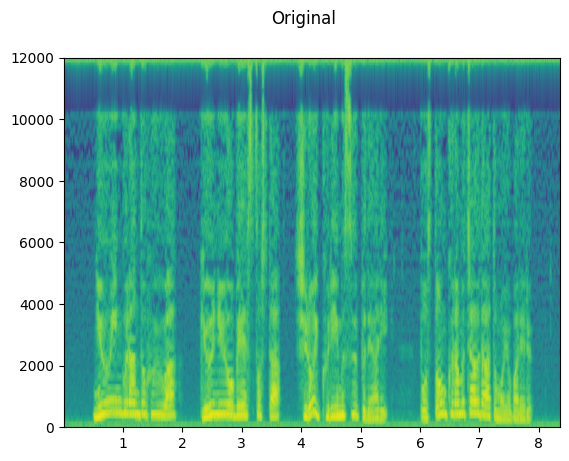

In [17]:
plot_specgram(xx_wave.unsqueeze(0), sample_rate=24000, title="Original")

In [18]:
tmptmp_wave = glim(invmel(tmptmp.detach()))

In [19]:
import IPython.display
IPython.display.Audio(tmptmp_wave, rate=24000)

(1, 147456)


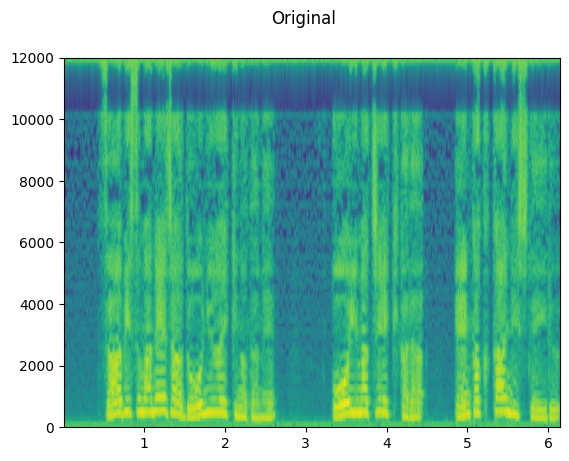

In [20]:
plot_specgram(tmptmp_wave.unsqueeze(0), sample_rate=24000, title="Original")

## 元音声の変換再合成

In [102]:
y = model(xx.unsqueeze(0).unsqueeze(0), tmptmp.unsqueeze(0).unsqueeze(0)).squeeze(0)
y_wave = glim(invmel(y.detach()))

In [103]:
import IPython.display
IPython.display.Audio(y_wave, rate=24000)

(1, 159488)


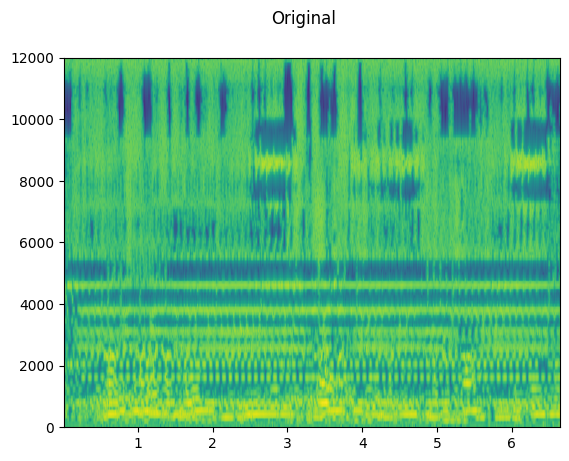

In [104]:
plot_specgram(y_wave, sample_rate=24000, title="Original")